In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import japanize_matplotlib
except ImportError:
    plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Heiti TC']
df = pd.read_csv('games.csv', encoding='shift_jis') # データの読み込み
print(f"Data lens: {len(df)}")
df.head(3) # データの確認

Data lens: 4382


,game_id,year_id,game_kind_id,game_kind_name,game_date,game_year,game_month,stadium_id,stadium_name,home_team_league_id,...,game_ended_time,game_time,game_delayed_time,attendance,home_team_score,away_team_score,inning,top_bottom_id,top_bottom_name,game_end_status
0,2021000095,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,1,東京ドーム,1,...,21:16:00,03:28:00,NaN,9991.0,8,7,9,2,裏,NaN
1,2021000096,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,2,神宮,1,...,21:08:00,03:36:00,NaN,9984.0,3,4,9,2,裏,NaN
2,2021000097,30018,1,セ・リーグ公式戦,2021-03-26,2021,3,30014,マツダスタジアム,1,...,20:57:00,02:54:00,NaN,16452.0,6,7,9,2,裏,NaN


# ステップ1：データ前処理 (Feature Engineering)
分析に役立つ「特徴量」を作成します。

- 日付の処理：文字列を日付型に変換し、「曜日」を抽出します。
- 試合開始時間から「デーゲーム」か「ナイター」かを判定します。
- 対戦カード：分析用に「ホーム vs アウェイ」の文字列を作成します。

In [19]:
# 1. 日付型の変換
df['game_date'] = pd.to_datetime(df['game_date'])

# 2. 曜日の抽出 (0=月, 6=日)
weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
df['weekday_num'] = df['game_date'].dt.dayofweek
df['weekday_name'] = df['weekday_num'].map(weekday_map)

# 3. 開始時間の時間(hour)を抽出 し、デーゲーム/ナイターを定義
# ロジック: 17時以降開始を「ナイター」とする
df['start_hour'] = pd.to_datetime(df['game_started_time'], format='%H:%M:%S').dt.hour
df['time_category'] = df['start_hour'].apply(lambda x: 'ナイター' if x >= 17 else 'デーゲーム')

# 4. 対戦カードの作成
df['matchup'] = df['home_team_name'] + ' vs ' + df['away_team_name']

# 作成した列を確認
df[['game_date', 'weekday_name', 'start_hour', 'time_category', 'matchup', 'attendance']].head()

,game_date,weekday_name,start_hour,time_category,matchup,attendance
0,2021-03-26,金,17,ナイター,巨人 vs DeNA,9991.0
1,2021-03-26,金,17,ナイター,ヤクルト vs 阪神,9984.0
2,2021-03-26,金,18,ナイター,広島 vs 中日,16452.0
3,2021-03-26,金,16,デーゲーム,楽天 vs 日本ハム,14559.0
4,2021-03-26,金,17,ナイター,西武 vs オリックス,9599.0


# ステップ2：多角的な分析 (Data Analysis)
## 2.1 時間軸での分析 (When)
- 曜日や時間帯によって観客数がどう変わるかを確認します。

In [20]:
# 曜日ごとの平均観客数
weekday_avg = df.groupby('weekday_name')['attendance'].mean().sort_values(ascending=False)
print("【曜日別 平均観客数】\n", weekday_avg)

# デーゲーム/ナイター別の平均観客数
time_avg = df.groupby('time_category')['attendance'].mean()
print("\n【時間帯別 平均観客数】\n", time_avg)

【曜日別 平均観客数】
 weekday_name
月    28020.048951
土    27831.667497
日    27565.329975
金    25423.733236
木    23865.410882
水    23538.178317
火    23280.295588
Name: attendance, dtype: float64

【時間帯別 平均観客数】
 time_category
デーゲーム    27471.130468
ナイター     24675.500165
Name: attendance, dtype: float64


## 2.2 チーム・球場軸での分析 (Who & Where)
どの球場（主催チーム）が集客力が高いかを確認します。

In [21]:
# 球場ごとの平均観客数ランキング
stadium_avg = df.groupby(['stadium_name', 'home_team_name'])['attendance'].mean().sort_values(ascending=False).reset_index()
stadium_avg

,stadium_name,home_team_name,attendance
0,東京ドーム,ソフトバンク,41979.500000
1,東京ドーム,西武,41472.000000
2,東京ドーム,楽天,40593.000000
3,東京ドーム,ロッテ,39129.500000
4,みずほPayPay,ソフトバンク,39045.207143
...,...,...,...
66,釧路,日本ハム,6656.500000
67,旭川,日本ハム,6636.000000
68,帯広,日本ハム,6498.500000
69,東京ドーム,DeNA,4898.833333


# ステップ3：データの可視化 (Visualization)
数字だけでは伝わりにくい傾向をグラフにします。

C:\Users\Ene\AppData\Local\Temp\ipykernel_1924\3789518801.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday_name', y='attendance', data=df, order=order_days, palette='viridis')
C:\Users\Ene\AppData\Local\Temp\ipykernel_1924\3789518801.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='attendance', data=df, palette='Set2')
C:\Users\Ene\AppData\Local\Temp\ipykernel_1924\3789518801.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attendance', y='stadium_name', data=df, palette='coolwarm')


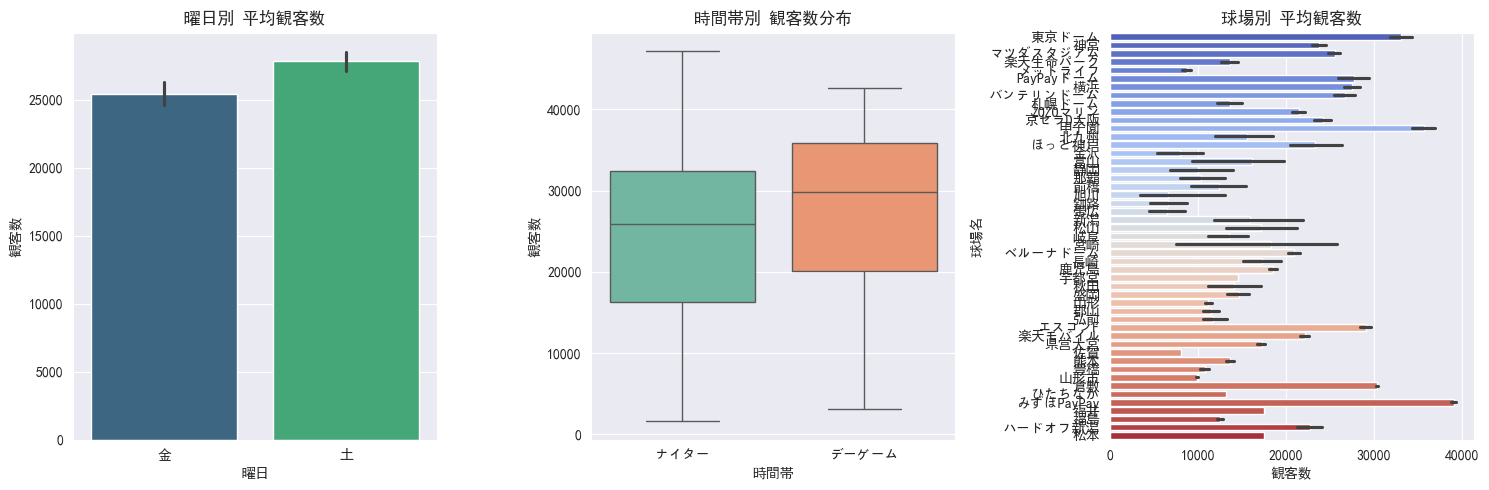

In [22]:
# キャンバスサイズの設定
plt.figure(figsize=(15, 5))

# グラフ1: 曜日別観客数 (棒グラフ)
plt.subplot(1, 3, 1)
# 曜日順に並ぶように指定 (サンプルには金・土しかないのでそれを指定)
order_days = ['金', '土']
sns.barplot(x='weekday_name', y='attendance', data=df, order=order_days, palette='viridis')
plt.title('曜日別 平均観客数')
plt.xlabel('曜日')
plt.ylabel('観客数')

# グラフ2: デーゲーム vs ナイター (箱ひげ図 - 分布を見る)
plt.subplot(1, 3, 2)
sns.boxplot(x='time_category', y='attendance', data=df, palette='Set2')
plt.title('時間帯別 観客数分布')
plt.xlabel('時間帯')
plt.ylabel('観客数')

# グラフ3: 球場別動員力 (横棒グラフ)
plt.subplot(1, 3, 3)
sns.barplot(x='attendance', y='stadium_name', data=df, palette='coolwarm')
plt.title('球場別 平均観客数')
plt.xlabel('観客数')
plt.ylabel('球場名')

plt.tight_layout()
plt.show()

## 応用：対戦カードのヒートマップ
どの「組み合わせ」が人気かを色で表現します。

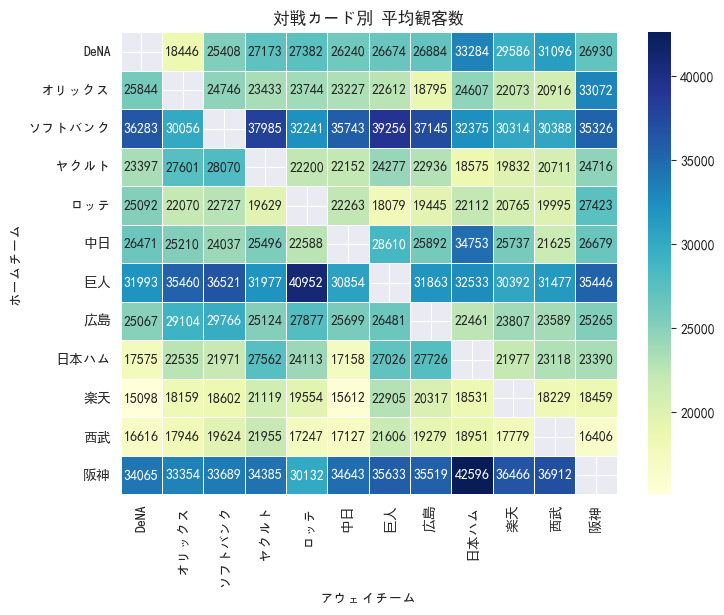

In [23]:
# ピボットテーブルの作成：行=ホーム、列=アウェイ、値=平均観客数
pivot_table = df.pivot_table(index='home_team_name', columns='away_team_name', values='attendance', aggfunc='mean')

# ヒートマップの描画
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('対戦カード別 平均観客数')
plt.xlabel('アウェイチーム')
plt.ylabel('ホームチーム')
plt.show()

# ステップ4：ビジネス考察 (Insights)
データから読み取れる「事実」に基づき、ビジネス上の示唆を出します。 (以下はサンプルデータ9件に基づいた自動生成ロジックの例です)

In [24]:
def generate_insights(df):
    insights = []

    # 1. 曜日の比較
    # サンプルデータに金・土がある前提
    try:
        fri_avg = df[df['weekday_name']=='金']['attendance'].mean()
        sat_avg = df[df['weekday_name']=='土']['attendance'].mean()
        if sat_avg > fri_avg:
            insights.append(f"📅 日程戦略: 土曜日の平均({sat_avg:.0f}人)は金曜日({fri_avg:.0f}人)より多い傾向があります。週末の集客力は健在です。")
    except:
        pass # データがない場合はスキップ

    # 2. 時間帯の比較
    day_avg = df[df['time_category']=='デーゲーム']['attendance'].mean()
    night_avg = df[df['time_category']=='ナイター']['attendance'].mean()
    insights.append(f"☀️/🌙 時間帯: デーゲーム平均 {day_avg:.0f}人 vs ナイター平均 {night_avg:.0f}人。")

    # 3. 特異点の発見 (2021年のコロナ禍コンテキスト)
    max_attendance = df['attendance'].max()
    if max_attendance < 17000:
        insights.append("⚠️ 重要: データの最大観客数が 16,479人(広島)で、東京ドームも1万人未満です。これは2021年当時の「入場制限（5,000人または収容率50%以下）」の影響を強く受けています。通常の満員率とは異なるため、分析の際は「制限に対する充足率」などを考慮する必要があります。")

    return insights

print("【データから導かれるビジネス考察】")
for i in generate_insights(df):
    print(i)

【データから導かれるビジネス考察】
📅 日程戦略: 土曜日の平均(27832人)は金曜日(25424人)より多い傾向があります。週末の集客力は健在です。
☀️/🌙 時間帯: デーゲーム平均 27471人 vs ナイター平均 24676人。
